样本数量为10000


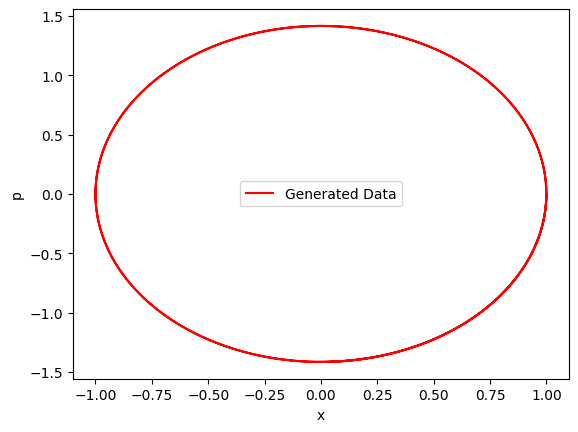

In [1]:
# 读取数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('harmonic_oscillator_trajectory.csv')
x = data['x'].to_numpy()
y = data['p'].to_numpy()
N = x.shape[0]
                  
print(f'样本数量为{N}')
# 可视化数据
plt.plot(x, y, color='r', label="Generated Data")
plt.legend()

plt.xlabel("x")
plt.ylabel("p")
plt.show()

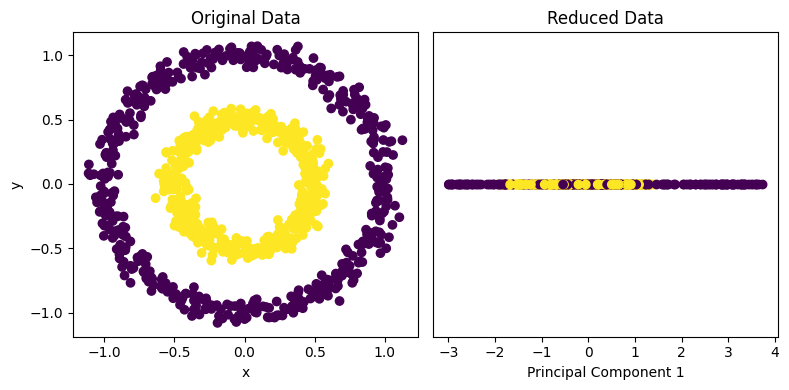

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 转换为 PyTorch 张量
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 定义 NLPCA 模型
class NLPCA(torch.nn.Module):
    def __init__(self, n_components):
        super(NLPCA, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, n_components)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_components, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 2)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 训练模型
n_components = 1  # 降维到 1 维
model = NLPCA(n_components)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    encoded, decoded = model(X_tensor)
    loss = criterion(decoded, X_tensor)
    loss.backward()
    optimizer.step()

# 降维后的数据
with torch.no_grad():
    encoded_np = model(X_tensor)[0].numpy()

# 可视化降维结果
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(encoded_np[:, 0], np.zeros_like(encoded_np[:, 0]), c=y, cmap='viridis')
plt.title('Reduced Data')
plt.xlabel('Principal Component 1')
plt.yticks([])

plt.tight_layout()
plt.show()